## SMS Text Classification
#### Section 2 : Prof. Tanya Roosta

### Members:
#### Hillary Chang, hillary_chang@berkeley.edu
#### Raji Chandrasekaran,  raji.chandrasekaran@berkeley.edu
#### Song Gao, song_gao@berkeley.edu


### Motivation
####  Natural Language Processing and text classification is something that is fundamentally required at a place where we are all bombarded with spam emails, messages etc. While classifying as SPAM or HAM is the beginning, text mining applications such as classifying if the author is showing irony or anger or other emotion is the next best application to develop using NLP.

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import os
import random

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools
import joblib
from xgboost import XGBClassifier


# import warnings
# warnings.filterwarnings("ignore")

random.seed(2)

2025-08-03 17:28:02.332591: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/raji/Documents/207 Python/jupyter-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = pd.read_csv("SMSSpamCollection", sep='\t', header=None, names=["label", "message"])

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Initial data counts
print(df.shape)
print(df['label'].value_counts())

(5572, 2)
label
ham     4825
spam     747
Name: count, dtype: int64


In [4]:
# converting labels to numeric identifiers
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

In [11]:
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


#### The message contains punctuations and uppercase and lowercase and spaces. We will need to standardize this using string pre processing. The folllowing function will handle all string pre processing needs

In [5]:
!pip install nltk


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [6]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()                              # lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # remove punctuation
    words = text.split()                             # tokenize
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_message'] = df['message'].apply(clean_text)

[nltk_data] Downloading package stopwords to /Users/raji/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df.head()

,label,message,label_num,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,0,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah dont think goe usf live around though


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          5572 non-null   object
 1   message        5572 non-null   object
 2   label_num      5572 non-null   int64 
 3   clean_message  5572 non-null   object
dtypes: int64(1), object(3)
memory usage: 174.2+ KB


#### Noticing that stemmer is converting "Entry" to "enrti" that may loose its original value. Trying Lemmetizer instead of stemmer

In [13]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def clean_text_with_lemmatizer(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_lem_message'] = df['message'].apply(clean_text_with_lemmatizer)

[nltk_data] Downloading package wordnet to /Users/raji/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/raji/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [14]:
df.head()

,label,message,label_num,clean_message,clean_lem_message
0,ham,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazi avail bugi n great world...,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entri 2 wkli comp win fa cup final tkt 21...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,u dun say earli hor u c alreadi say,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah dont think goe usf live around though,nah dont think go usf life around though


In [15]:
# Other outlier detection & null values detection for a cleaner dataset before we split for train test and validation
print(df.isnull().sum())

label                0
message              0
label_num            0
clean_message        0
clean_lem_message    0
dtype: int64


In [16]:
# Other outlier detection & null values detection for a cleaner dataset before we split for train test and validation
print(df.isnull().sum())

label                0
message              0
label_num            0
clean_message        0
clean_lem_message    0
dtype: int64


#### EDA & Visualizations

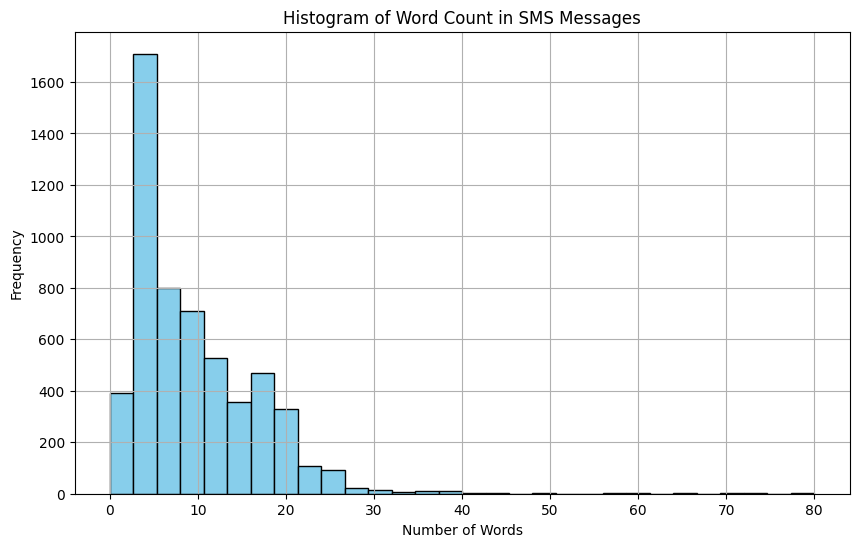

In [17]:
df['word_count'] = df['clean_lem_message'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Count in SMS Messages')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

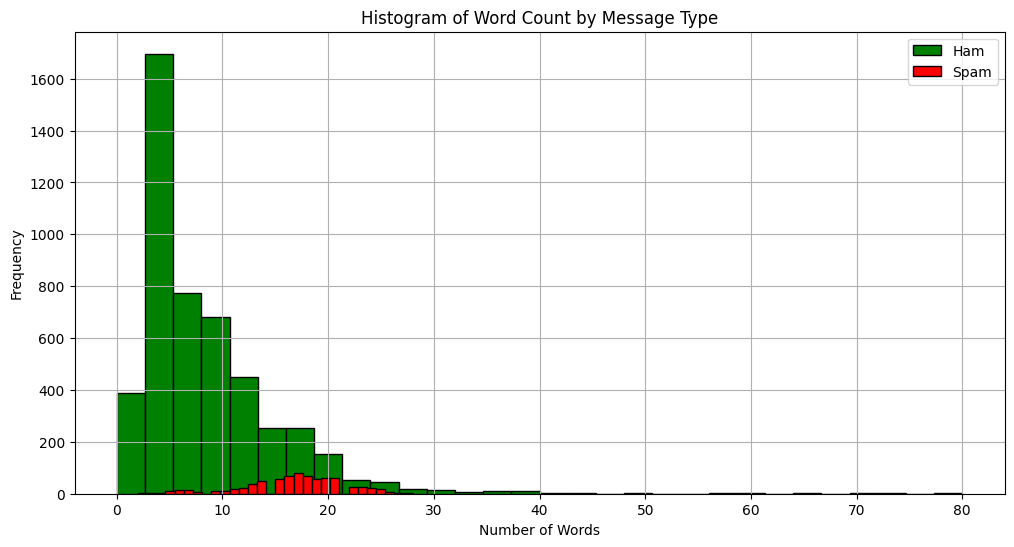

In [18]:
plt.figure(figsize=(12, 6))

# Ham
plt.hist(df[df['label'] == 'ham']['word_count'], bins=30,  label='Ham', color='green', edgecolor='black')

# Spam
plt.hist(df[df['label'] == 'spam']['word_count'], bins=30, label='Spam', color='red', edgecolor='black')

plt.title('Histogram of Word Count by Message Type')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

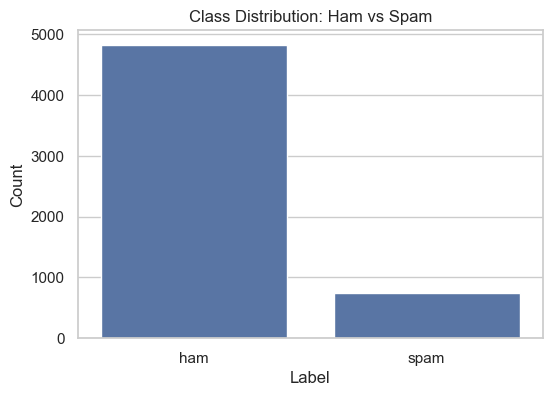

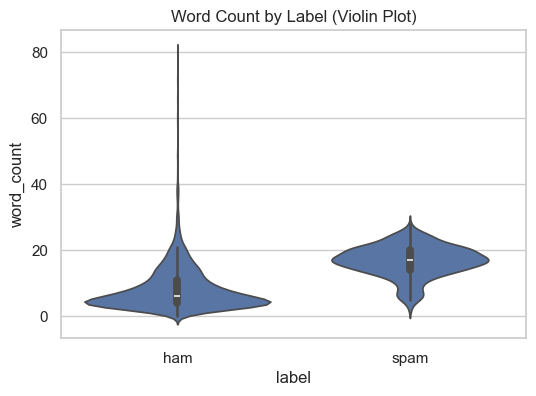

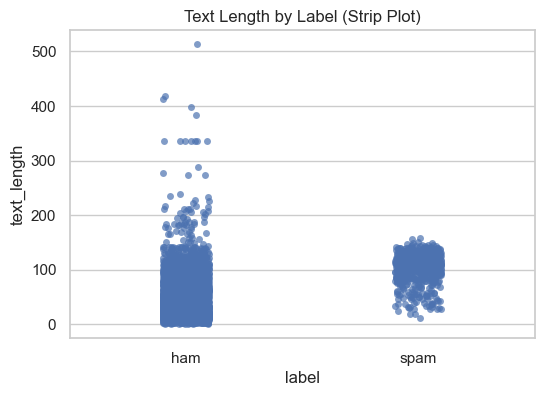

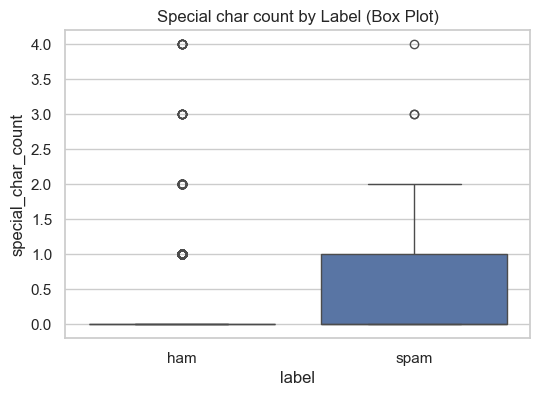

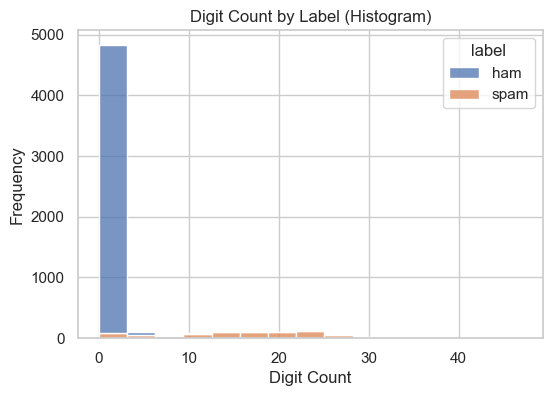

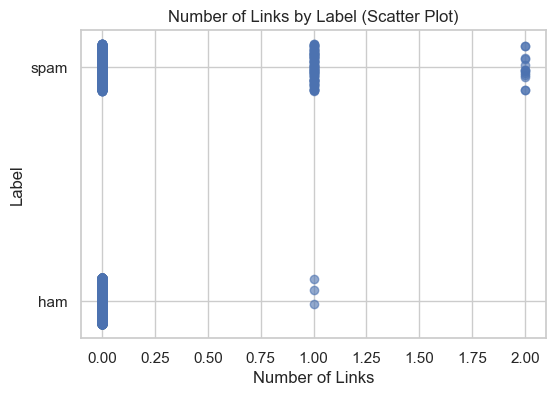

In [19]:
# Add more features for spam detections
df['word_count'] = df['clean_lem_message'].apply(lambda x: len(x.split()))
df['text_length'] = df['clean_lem_message'].apply(lambda x: len(x))
df['special_char_count'] = df['clean_lem_message'].apply(lambda x: len(re.findall(r'[^A-Za-z0-9 ]', x)))
df['digit_count'] = df['clean_lem_message'].apply(lambda x: sum(c.isdigit() for c in x))
df['num_links'] = df['clean_lem_message'].apply(lambda x: len(re.findall(r'(http|www|\.com)', x.lower())))

# Set seaborn style
sns.set(style="whitegrid")

# Plot 1: Class Distribution (Bar Plot)
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title("Class Distribution: Ham vs Spam")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Plot 2: Word Count (Violin Plot)
plt.figure(figsize=(6, 4))
sns.violinplot(x='label', y='word_count', data=df)
plt.title("Word Count by Label (Violin Plot)")
plt.show()

# Plot 3: Text Length (Strip Plot)
plt.figure(figsize=(6, 4))
sns.stripplot(x='label', y='text_length', data=df, jitter=True, alpha=0.7)
plt.title("Text Length by Label (Strip Plot)")
plt.show()

# Plot 4: Special Char Count (Box Plot)
plt.figure(figsize=(6, 4))
sns.boxplot(x='label', y='special_char_count', data=df)
plt.title("Special char count by Label (Box Plot)")
plt.show()

# Plot 5: Digit Count (Histogram)
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='digit_count', hue='label', multiple='stack', bins=15)
plt.title("Digit Count by Label (Histogram)")
plt.xlabel("Digit Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot 6: Number of Links (Scatter)
# Map labels to numeric values
label_map = {'ham': 0, 'spam': 1}
df['label_numeric'] = df['label'].map(label_map)
# Add jitter to the y-axis for better visual separation
y_jitter = df['label_numeric'] + np.random.uniform(-0.1, 0.1, size=len(df))
plt.figure(figsize=(6, 4))
plt.scatter(df['num_links'], y_jitter, alpha=0.6)
plt.yticks([0, 1], ['ham', 'spam'])
plt.xlabel("Number of Links")
plt.ylabel("Label")
plt.title("Number of Links by Label (Scatter Plot)")
plt.grid(True)
plt.show()

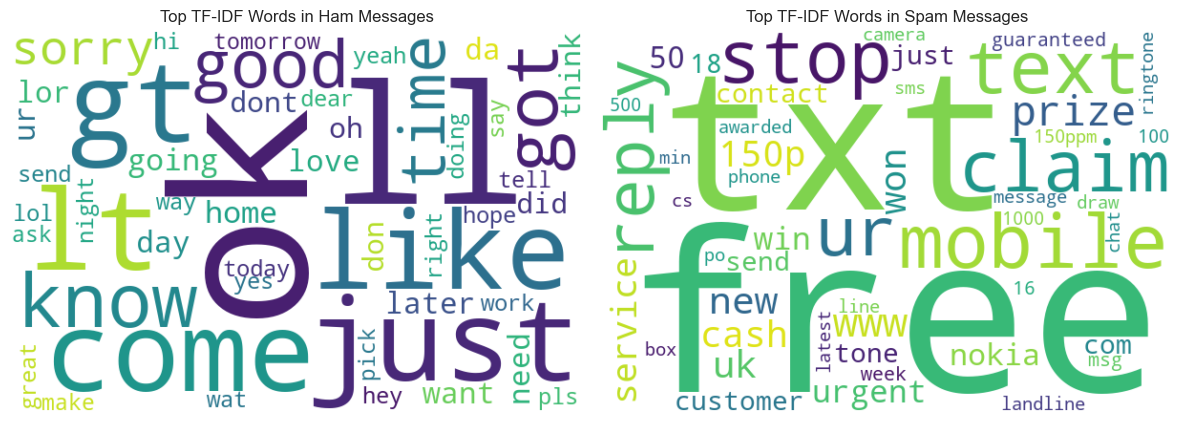

In [20]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['message'])
feature_names = vectorizer.get_feature_names_out()

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df['label'] = df['label'].values

# Top words for ham and spam
ham_words = tfidf_df[tfidf_df['label'] == 'ham'].drop(columns='label').sum().sort_values(ascending=False).head(50)
spam_words = tfidf_df[tfidf_df['label'] == 'spam'].drop(columns='label').sum().sort_values(ascending=False).head(50)

# Word clouds
ham_wc = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(ham_words)
spam_wc = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(spam_words)

# Display Word Clouds
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Top TF-IDF Words in Ham Messages')

plt.subplot(1, 2, 2)
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Top TF-IDF Words in Spam Messages')
plt.tight_layout()
plt.show()

## Methodology

To classify SMS messages as spam or ham, we wanted to start with a simple model for baseline performance and then test two more advanced models that could potentially have improved performance.

### Models

Our simple baseline model would be a Logistic Regression model because it is easy to implement, fast to train, and efficient with TF-IDF-transformed text data.

Our more advanced model would be a Random Forest model because it captures nonlinear relationships well and isn't as sensitive to overfitting as individual decision trees.

For our second, more advanced model, we chose XGBoost because it is known for having strong performance on classification tasks and can handle imbalanced data better than many other models.

### Testing

First, we are using TF-IDF to convert the messages into vectors. We then split the data into 60% training, 20% validation, and 20% test, while making sure the spam/ham ratio stays the same in each split. We use GridSearchCV for hyperparameter tuning to find the optimal hyperamaters in each model (ex. optimal number of estimators in Random Forest or optimal learning rate in XGBoost). Our validation set is necessary to compare models and avoid overfitting on the training data.

### Metrics

Because only about 13% of the dataset is spam, accuracy on its own isn’t helpful. Therefore, for metrics, we are looking at precision, recall, F1-Score, and ROC AUC. Looking at precision ensures we do not mark legit messages as spam. Similarily, recall ensures we do not miss actual spam. The F1-Score balances out precision and recall. ROC AUC is useful for comparing the overall model performance by looking at the True Positive Rate and False Positive Rate.

In [22]:
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
df['message_length'] = df['message'].apply(len)
df['length_group'] = pd.qcut(df['message_length'], q=3, labels=["Short", "Medium", "Long"])

tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, max_features=3000)
X_all = tfidf.fit_transform(df['message'])
y_all = df['label_num']
X_all_dense = X_all.toarray()

joblib.dump(tfidf, "tfidf_vectorizer.pkl")

X_train_val, X_test, y_train_val, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

In [23]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
joblib.dump(lr, "logistic_regression.pkl")

# Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10]}
grid_rf = GridSearchCV(rf, rf_params, cv=3, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
joblib.dump(best_rf, "random_forest.pkl")

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
#  XG Boost with Random
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Dimensionality reduction to help XGBoost
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_reduced = svd.fit_transform(X_train)
X_val_reduced = svd.transform(X_val)
X_test_reduced = svd.transform(X_test)


xgb_random = RandomizedSearchCV(
    estimator=XGBClassifier(
        eval_metric="logloss",
        scale_pos_weight=pos_weight,
        random_state=42
    ),
    param_distributions={
        'n_estimators': randint(100, 300),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.7, 0.3),
        'gamma': uniform(0, 1),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0.5, 1.5)
    },
    n_iter=50,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

xgb_random.fit(X_train_reduced, y_train)
best_xgb = xgb_random.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [24]:
def evaluate_model(name, model, X_val, y_val, X_test, y_test, dense=False):
    print(f"\n{name} - Validation Set")
    Xv = X_val.toarray() if dense else X_val
    val_preds = model.predict(Xv)
    val_probs = model.predict_proba(Xv)[:, 1]
    print(classification_report(y_val, val_preds))
    print("ROC AUC:", roc_auc_score(y_val, val_probs))

    print(f"\n{name} - Test Set")
    Xt = X_test.toarray() if dense else X_test
    test_preds = model.predict(Xt)
    test_probs = model.predict_proba(Xt)[:, 1]
    print(classification_report(y_test, test_preds))
    print("ROC AUC:", roc_auc_score(y_test, test_probs))

evaluate_model("Logistic Regression", lr, X_val, y_val, X_test, y_test)
evaluate_model("Random Forest", best_rf, X_val, y_val, X_test, y_test)
evaluate_model("XGBoost", best_xgb, X_val_reduced, y_val, X_test_reduced, y_test)


Logistic Regression - Validation Set
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.97      0.88      0.92       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

ROC AUC: 0.9924145077720207

Logistic Regression - Test Set
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       966
           1       0.90      0.89      0.89       149

    accuracy                           0.97      1115
   macro avg       0.94      0.94      0.94      1115
weighted avg       0.97      0.97      0.97      1115

ROC AUC: 0.985889365959398

Random Forest - Validation Set
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       0.98      0.82      0.89       150

    accuracy             

In [35]:
def get_subgroup_scores(model, model_name, X, y, input_type='sparse'):
    scores = []
    for group in df['length_group'].unique():
        indices = df[df['length_group'] == group].index
        X_group = X[indices]
        y_true = y.iloc[indices]
        y_pred = model.predict(X_group)
        scores.append({
            "Model": model_name,
            "Group": group,
            "F1 Score": f1_score(y_true, y_pred)
        })
    return scores
X_all_reduced = svd.transform(X_all_dense)

lr_scores = get_subgroup_scores(lr, "Logistic Regression", X_all, y_all)
rf_scores = get_subgroup_scores(best_rf, "Random Forest", X_all, y_all)
xgb_scores = get_subgroup_scores(best_xgb, "XGBoost", X_all_reduced, y_all, input_type='dense')
subgroup_df = pd.DataFrame(lr_scores + rf_scores + xgb_scores)


In [36]:
models = ["Logistic Regression", "Random Forest", "XGBoost"]
groups = ["Short", "Medium", "Long"]
full_index = pd.DataFrame(list(itertools.product(models, groups)), columns=["Model", "Group"])
merged_df = pd.merge(full_index, subgroup_df, on=["Model", "Group"], how="left")

In [39]:
pivot_df = merged_df.pivot(index='Group', columns='Model', values='F1 Score')

In [40]:
pivot_df

Model,Logistic Regression,Random Forest,XGBoost
Group,,,
Long,0.973134,0.970522,0.979896
Medium,0.859649,0.871287,0.886957
Short,0.315789,0.533333,0.444444


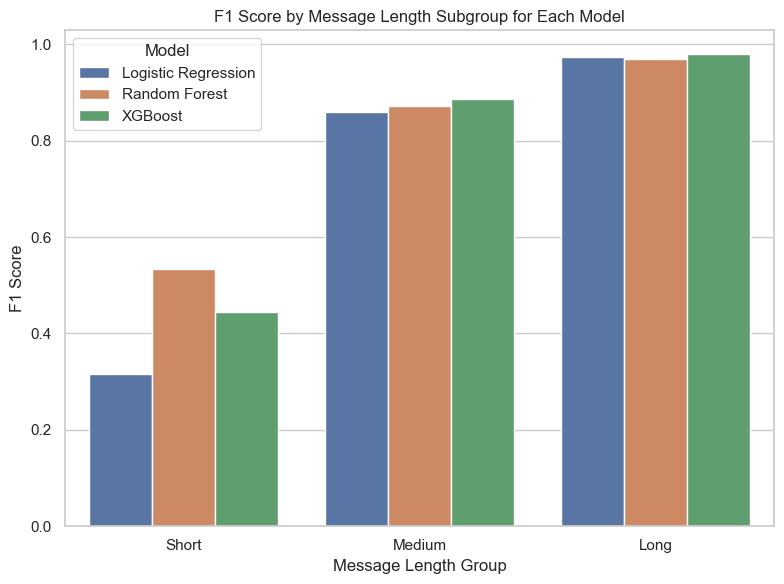

In [38]:
plt.figure(figsize=(8, 6))
sns.barplot(data=merged_df, x="Group", y="F1 Score", hue="Model")
plt.title("F1 Score by Message Length Subgroup for Each Model")
#plt.ylim(0.7, 1.05)
plt.xlabel("Message Length Group")
plt.ylabel("F1 Score")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

In [ ]:
# While medium and Long group scores are very comparible, Short group scores are where scores vary. 
# Random Forest does better on Short group F1 score compared to XG Boost and Logistic Regression


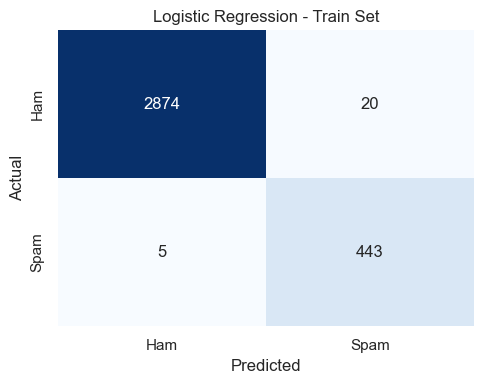

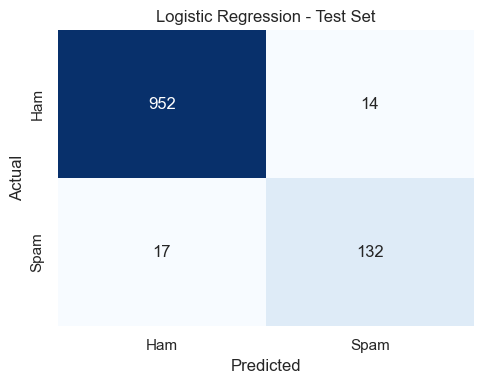

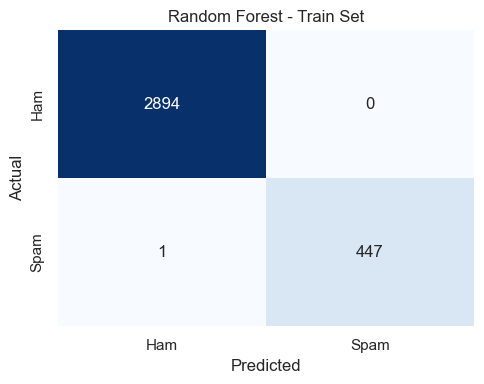

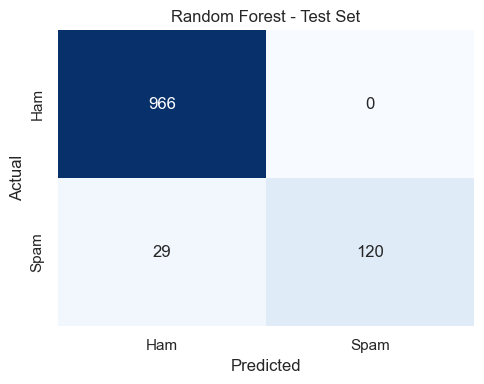

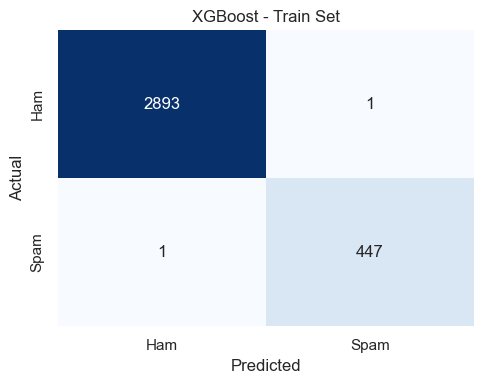

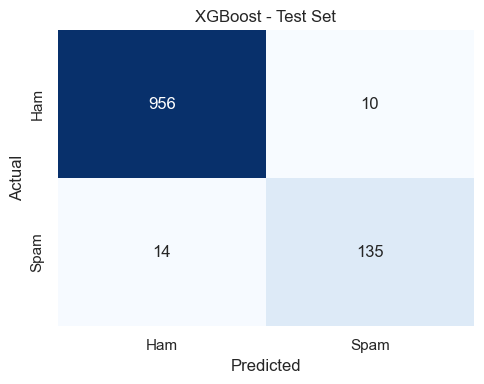

In [41]:
# Confusion matrices

models = {
    "Logistic Regression": (lr, X_train, X_test),
    "Random Forest": (best_rf, X_train, X_test),
    "XGBoost": (best_xgb, X_train_reduced, X_test_reduced)
}

y_sets = [y_train, y_test]
set_names = ["Train Set", "Test Set"]

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for model_name, (model, X_train_input, X_test_input) in models.items():
    for X, y, label in zip([X_train_input, X_test_input], y_sets, set_names):
        preds = model.predict(X)
        cm = confusion_matrix(y, preds)

        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"{model_name} - {label}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.xticks([0.5, 1.5], ["Ham", "Spam"])
        plt.yticks([0.5, 1.5], ["Ham", "Spam"])
        plt.tight_layout()
        plt.show()


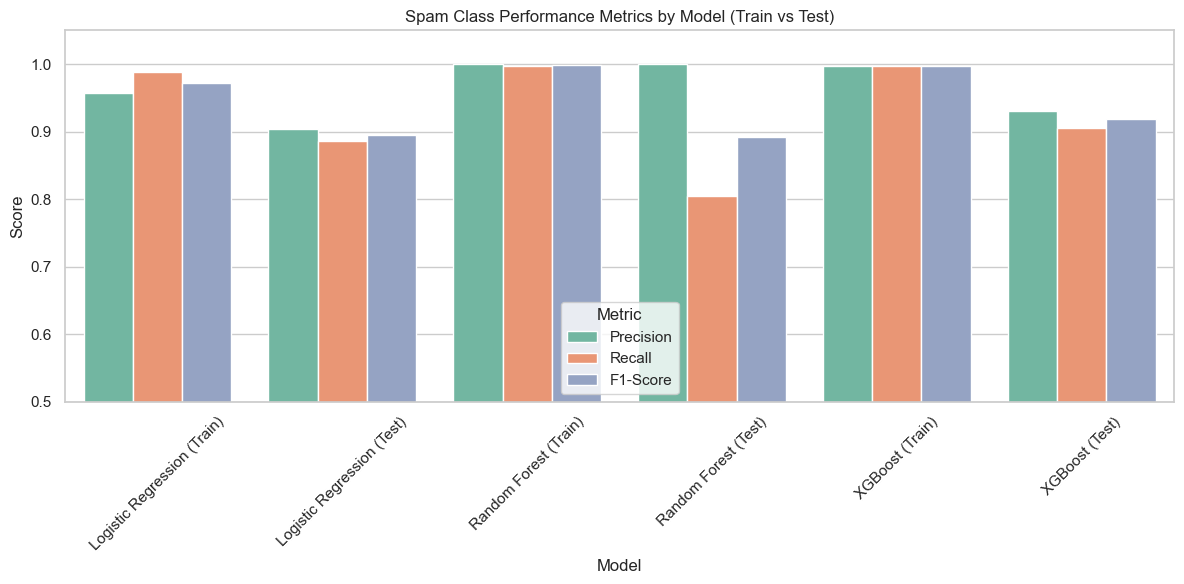

In [42]:
# Map each model to its expected input type
models = {
    "Logistic Regression": (lr, X_train, X_test),
    "Random Forest": (best_rf, X_train, X_test),
    "XGBoost": (best_xgb, X_train_reduced, X_test_reduced)
}

metrics = []

for model_name, (model, X_tr, X_te) in models.items():
    for X, y, dataset in zip([X_tr, X_te], [y_train, y_test], ["Train", "Test"]):
        preds = model.predict(X)
        report = classification_report(y, preds, output_dict=True, zero_division=0)
        metrics.append({
            "Model": f"{model_name} ({dataset})",
            "Precision": report['1']['precision'],
            "Recall": report['1']['recall'],
            "F1-Score": report['1']['f1-score']
        })

df_metrics = pd.DataFrame(metrics)
df_melted = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric", palette="Set2")
plt.title("Spam Class Performance Metrics by Model (Train vs Test)")
plt.xticks(rotation=45)
plt.ylim(0.5, 1.05)
plt.tight_layout()
plt.show()


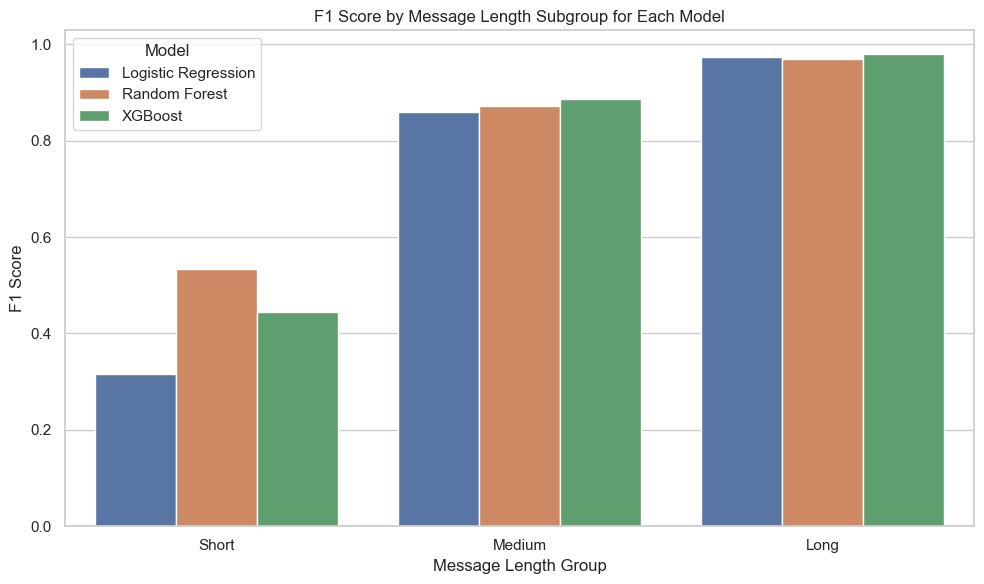

In [43]:
models = ["Logistic Regression", "Random Forest", "XGBoost"]
groups = ["Short", "Medium", "Long"]

full_index = pd.DataFrame(list(itertools.product(models, groups)), columns=["Model", "Group"])

merged_df = pd.merge(full_index, subgroup_df, on=["Model", "Group"], how="left")

plt.figure(figsize=(10, 6))
sns.barplot(data=merged_df, x="Group", y="F1 Score", hue="Model")
plt.title("F1 Score by Message Length Subgroup for Each Model")
#plt.ylim(0.7, 1.05)
plt.xlabel("Message Length Group")
plt.ylabel("F1 Score")
plt.legend(title="Model")
plt.tight_layout()
plt.show()